In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from lib import make_corrfig, linearize, get_flat_inds_for_net, triangularizeweights
from data_loader import data_loader
import warnings
warnings.simplefilter('ignore')

## Load demographic and connectivity data 
#### Group labels: TS = Tourette syndrome partcipant; TFC = control partcipant

In [2]:
demo = pd.read_csv('data/demo.csv', names=['VC', 'Age', 'Group'])

demo_ts = demo.where(demo.Group=='TS').dropna().reset_index(drop=True)
demo_hc = demo.where(demo.Group=='TFC').dropna().reset_index(drop=True)

In [3]:
demo_ts

,VC,Age,Group
0,vc39607,13.00,TS
1,vc39504,9.70,TS
2,vc39703,14.60,TS
3,vc39503,11.80,TS
4,vc39771,11.10,TS
...,...,...,...
94,vc39687,24.90,TS
95,vc39746,34.06,TS
96,vc39784,30.55,TS
97,vc39845,29.79,TS


In [4]:
# custom data loader reads in connectivity data for each group seperately
ts_con = data_loader(demo_ts)
hc_con = data_loader(demo_hc)

Shape of loaded data: ts-(352, 352, 99); hc-(352, 352, 99)

Functional connectivity data is essentialy just correlation matricies, based off measured brain activity
at different locations. Here we are recordinig from 352 regions in the brain, and take the pairwise correlation 
between each timeseries. The result is a 352 x 352 correlation matrix. We load this matrix for each participant
in the data set (n = 99 HC, n = 99 TS)

The average connectivity for a group can be calculated and shown


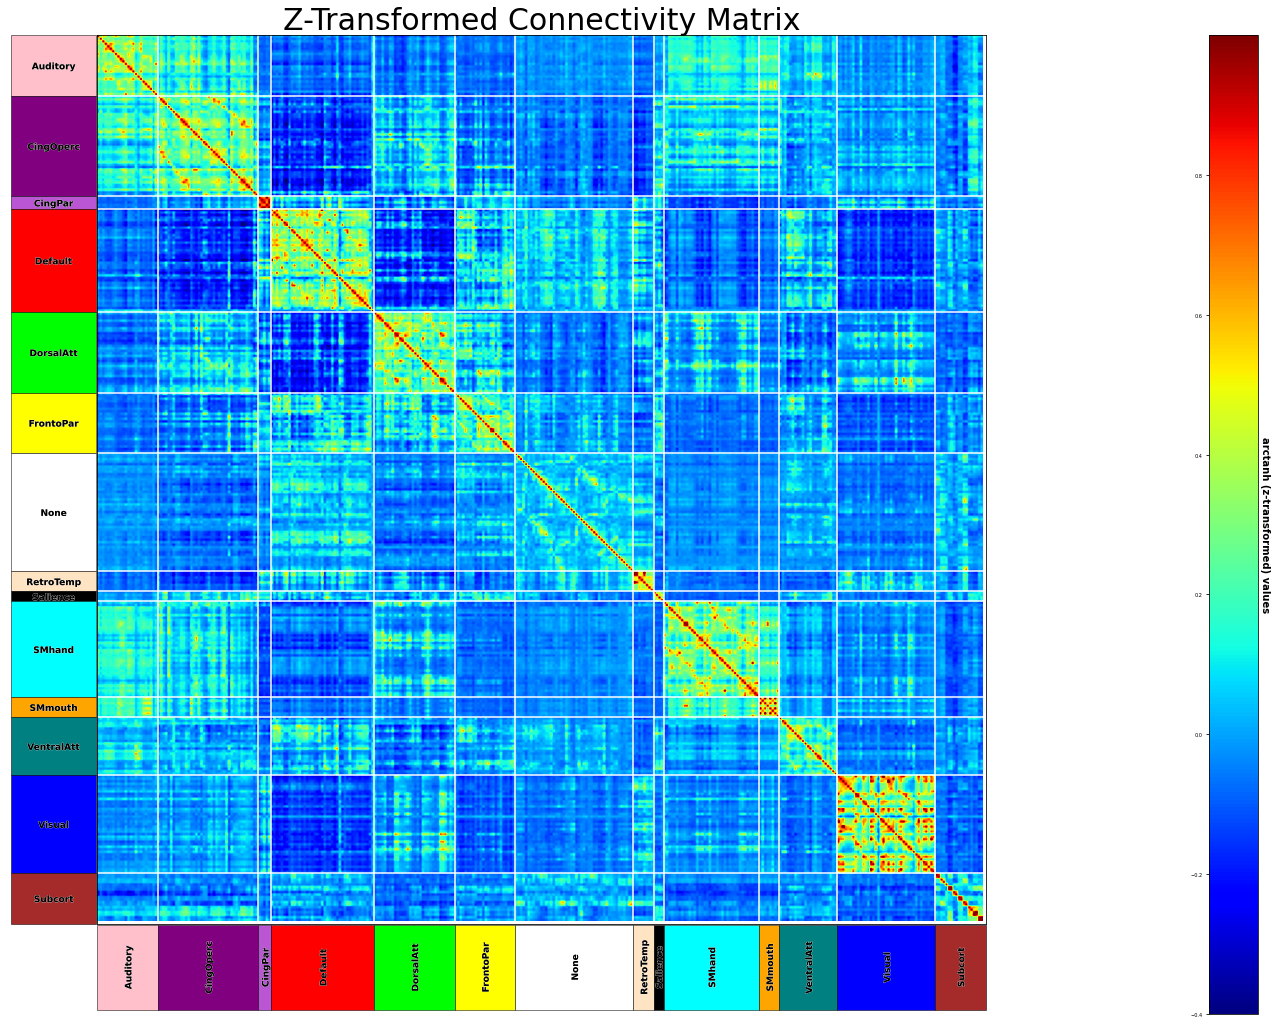

In [5]:
print(f"Shape of loaded data: ts-{ts_con.shape}; hc-{hc_con.shape}\n")

print("""Functional connectivity data is essentialy just correlation matricies, based off measured brain activity
at different locations. Here we are recordinig from 352 regions in the brain, and take the pairwise correlation 
between each timeseries. The result is a 352 x 352 correlation matrix. We load this matrix for each participant
in the data set (n = 99 HC, n = 99 TS)\n""")

print("The average connectivity for a group can be calculated and shown")

average_ts_connectivity = np.mean(ts_con,2)
make_corrfig(average_ts_connectivity)


In [6]:
# Connectivity matricies are symettric and square. We need just the flattened upper or lower triangle, of the matrix
# to create a new design matrix

In [24]:
ts_con_flat = linearize(ts_con)
hc_con_flat = linearize(hc_con)


# create feature matrix
X = np.vstack((hc_con_flat, ts_con_flat))

# create label vector: 1 for HC, -1 for TS
y = np.concatenate((np.repeat(1,99), np.repeat(-1,99)))

## Classification  
#### LOOCV with SVM (C = 1) 

In [25]:
cv = LeaveOneOut()
clf = svm.SVC(kernel='linear', C=1, random_state=1)
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-2)
print('LOOCV Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

LOOCV Accuracy: 0.672 (0.470)


In [17]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

In [52]:
cv = LeaveOneOut()
clfsvm = svm.SVC(kernel='linear', C=1, random_state=1)
scores = cross_val_score(clfsvm, X_scale, y, scoring='accuracy', cv=cv, n_jobs=-2)
print('LOOCV Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

LOOCV Accuracy: 0.682 (0.466)


#### Random Forest

In [16]:
cv = LeaveOneOut()
clfrf = RandomForestClassifier(n_estimators=400)
scores = cross_val_score(clfrf, X_scale, y, scoring='accuracy', cv=cv, n_jobs=-2)
print('LOOCV Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

#### Feature Importance

In [63]:
clfrfall = RandomForestClassifier(n_estimators=1500)
clfrfall.fit(X_scale, y)

RandomForestClassifier(n_estimators=1500)

In [64]:
pred = clfrfall.predict(X_scale)
report = classification_report(y, pred)
print(report)

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        99
           1       1.00      1.00      1.00        99

    accuracy                           1.00       198
   macro avg       1.00      1.00      1.00       198
weighted avg       1.00      1.00      1.00       198



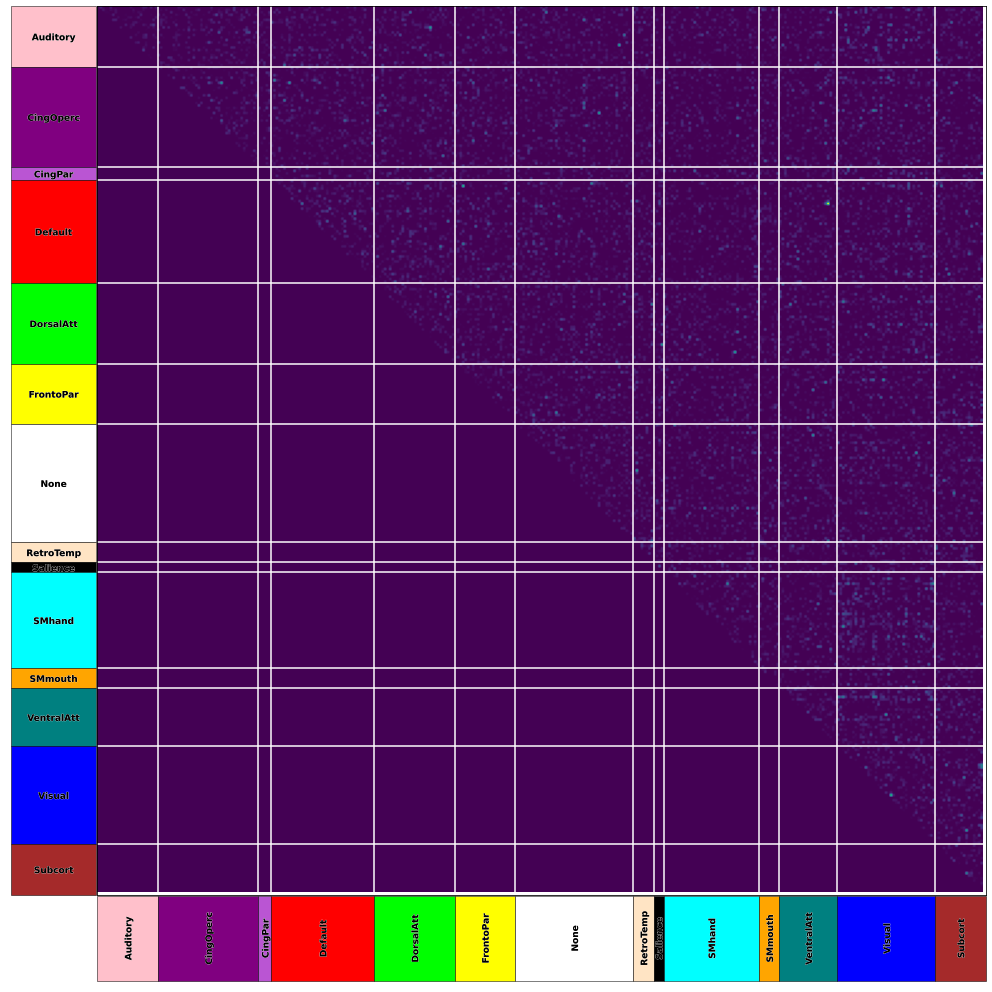

In [65]:
make_corrfig(triangularizeweights(clfrfall.feature_importances_), weights=True)

In [70]:
netlist = ['Auditory','CingOperc','CingPar','Default','DorsalAtt','FrontoPar','None', 'RetroTemp','Salience','SMhand','SMmouth','VentralAtt','Visual','Subcort']   


mean_importance = []
for net in netlist:
    mean_importance.append(np.mean(clfrfall.feature_importances_[get_flat_inds_for_net(net, within=True)]))


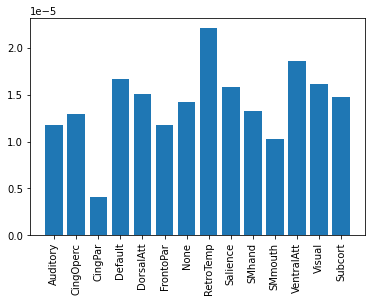

In [71]:
plt.bar(range(len(netlist)), mean_importance, align='center')
plt.xticks(range(len(netlist)), netlist, rotation=90)
plt.show()